İmport Dependencies

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn as nn
import torchvision
import glob
import random

In [26]:
data = pd.read_csv("/home/nmp/Desktop/Tez/masterthesis/data/nuh/dokum1calib/dokum1calib_1_1_5470558.csv", encoding = "ISO-8859-1", skiprows=11,delim_whitespace =True,header = None)

In [27]:
data.head()

,0
0,0.002747
1,0.001526
2,0.000305
3,-0.000916
4,0.000305


In [54]:
out = data.loc[:,0].values
out = (out-out.min())/(out.max()-out.min())

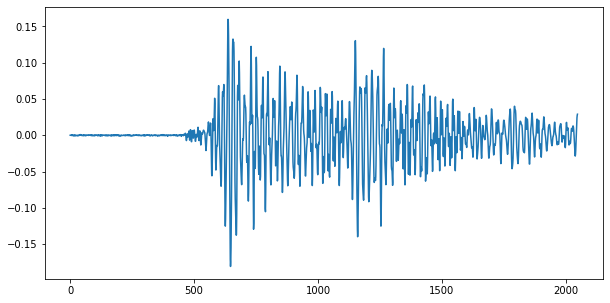

In [56]:
plt.figure(figsize = (10,5))
plt.plot(data)

In [50]:
path = "/home/nmp/Desktop/Tez/masterthesis/data/nuh"
datas = glob.glob(path+"/**/*.csv")
random.shuffle(datas)

In [53]:
data_total = []
for i in datas:
    data_path  =i
    data = pd.read_csv(data_path, encoding = "ISO-8859-1", skiprows=11,delim_whitespace =True,header = None)
    if data.loc[:,0].values[None].shape[1]!=2048: continue
    data_total.append(data_path)

## Model Definition

In [29]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [31]:
class Dataloader:
    def __init__(self,datas):
        self.train = datas
    def __len__(self):
        return len(self.train)

    def __getitem__(self, idx):
        data  =self.train(idx)
        data = pd.read_csv(data, encoding = "ISO-8859-1", skiprows=11,delim_whitespace =True,header = None)
        return data

In [43]:

path = "/home/nmp/Desktop/Tez/masterthesis/data/nuh"
datas = glob.glob(path+"/**/*.csv")
print("Total Data Size:",len(datas))
random.shuffle(datas)
test_datas = datas[int(len(datas)*0.9):]
train_datas = datas[:int(len(datas)*0.9)]
print("Test Datas::",len(test_datas))
print("Train Datas:",len(train_datas))

Total Data Size: 5443
Test Datas:: 545
Train Datas: 4898


In [47]:

train_dataset = Dataloader(train_datas)

test_dataset = Dataloader(test_datas)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)
epochs = 100

In [48]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/nmp/.virtualenvs/venvb/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/nmp/.virtualenvs/venvb/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/nmp/.virtualenvs/venvb/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-31-02fa02e94f2a>", line 8, in __getitem__
    data  =self.train(idx)
TypeError: 'list' object is not callable
